In [75]:
import geopandas as gpd
import pandas as pd
import shapely
import numpy as np
import matplotlib.pyplot as plt

In [76]:
# Import SC data into a geodataframe
sc_cong_gdf = gpd.read_file("S865_Congress/S865_Congress.shp")
sc_cong_gdf.columns

Index(['DISTRICT', 'POPULATION', 'DEVIATION', 'F_DEVIATIO', 'HISPANIC_O',
       'F_HISPANIC', 'NH_WHT', 'F_NH_WHT', 'NH_DOJ_BLK', 'F_NH_DOJ_B',
       'F18_POP', 'F_18_POP', 'H18_POP', 'F_H18_POP', 'NH18_WHT', 'F_NH18_WHT',
       'NH18_DOJ_B', 'F_NH18_DOJ', 'geometry'],
      dtype='object')

<Axes: >

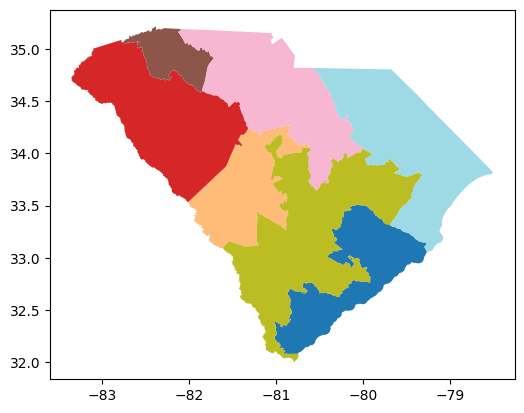

In [77]:
sc_cong_gdf.plot(cmap = "tab20")

In [78]:
# Import 2022 General Election voting data
sc_data_gdf = gpd.read_file('sc_2022_gen_prec/sc_2022_gen_st_prec/sc_2022_gen_st_prec.shp')
sc_data_gdf.columns

Index(['UNIQUE_ID', 'COUNTYFP', 'County', 'Precinct', 'Prec_Code', 'G22A1NO',
       'G22A1YES', 'G22A2NO', 'G22A2YES', 'G22AGRCNEL', 'G22AGRGEDM',
       'G22AGROWRI', 'G22AGRRWEA', 'G22ATGOWRI', 'G22ATGRWIL', 'G22COMOWRI',
       'G22COMRECK', 'G22GOVDCUN', 'G22GOVLREE', 'G22GOVOWRI', 'G22GOVRMCM',
       'G22SOSDBUT', 'G22SOSOWRI', 'G22SOSRHAM', 'G22SUPAELL', 'G22SUPDELL',
       'G22SUPGMIC', 'G22SUPOWRI', 'G22SUPRWEA', 'G22TREAWOR', 'G22TREOWRI',
       'G22TRERLOF', 'G22USSDMAT', 'G22USSOWRI', 'G22USSRSCO', 'geometry'],
      dtype='object')

In [79]:
# List of specific columns to keep
columns_to_keep = ['UNIQUE_ID', 'COUNTYFP', 'County', 'Precinct', 'Prec_Code', 'geometry']

# Add columns starting with 'G22USS'
filtered_columns = columns_to_keep + [col for col in sc_data_gdf.columns if col.startswith('G22USS')]

# Filter the GeoDataFrame
sc_data_gdf = sc_data_gdf[filtered_columns]

In [80]:
sc_data_gdf.columns

Index(['UNIQUE_ID', 'COUNTYFP', 'County', 'Precinct', 'Prec_Code', 'geometry',
       'G22USSDMAT', 'G22USSOWRI', 'G22USSRSCO'],
      dtype='object')

Need to add district to this so we are going to left join with data from general election congressional precinct data but only add the district column.

In [82]:
sc_data_cong_gdf = gpd.read_file('sc_2022_gen_prec/sc_2022_gen_cong_prec/sc_2022_gen_cong_prec.shp')
sc_data_gdf = sc_data_gdf.merge(sc_data_cong_gdf[['Prec_Code', 'CONG_DIST']], on='Prec_Code', how='left')

In [83]:
# How districts are inputted into the data dataframe
sc_data_gdf["CONG_DIST"].unique()

array(['03', '02', '06', '01', '05', '07', '04'], dtype=object)

In [84]:
# How districts are inputted into the shapefile dataframe
sc_cong_gdf["DISTRICT"].unique()

array(['1', '2', '3', '4', '5', '6', '7'], dtype=object)

In [85]:
# Make the data dataframe as the districts inputted in the same manner as the shapefile so we can join
sc_data_gdf['CONG_DIST'] = sc_data_gdf['CONG_DIST'].astype(str).str.lstrip('0')
sc_data_gdf["CONG_DIST"].unique()

array(['3', '2', '6', '1', '5', '7', '4'], dtype=object)

In [86]:
sc_cong_gdf = sc_cong_gdf.merge(sc_data_gdf, left_on='DISTRICT', right_on='CONG_DIST', how='inner')

In [87]:
sc_cong_gdf.head()

,DISTRICT,POPULATION,DEVIATION,F_DEVIATIO,HISPANIC_O,F_HISPANIC,NH_WHT,F_NH_WHT,NH_DOJ_BLK,F_NH_DOJ_B,...,UNIQUE_ID,COUNTYFP,County,Precinct,Prec_Code,geometry_y,G22USSDMAT,G22USSOWRI,G22USSRSCO,CONG_DIST
0,1,731203,-1.0,-0.000001,59591,0.081497,498807,0.682173,130245,0.178124,...,ABBEVILLE-:-ABBEVILLE NO. 1,001,ABBEVILLE,ABBEVILLE NO. 1,001,"POLYGON ((1606939.510 874521.176, 1606937.194 ...",212,0,772,1
1,1,731203,-1.0,-0.000001,59591,0.081497,498807,0.682173,130245,0.178124,...,ABBEVILLE-:-ABBEVILLE NO. 1,001,ABBEVILLE,ABBEVILLE NO. 1,001,"POLYGON ((1606939.510 874521.176, 1606937.194 ...",212,0,772,1
2,1,731203,-1.0,-0.000001,59591,0.081497,498807,0.682173,130245,0.178124,...,ABBEVILLE-:-ABBEVILLE NO. 2,001,ABBEVILLE,ABBEVILLE NO. 2,002,"POLYGON ((1594909.405 858817.595, 1594971.672 ...",395,1,236,1
3,1,731203,-1.0,-0.000001,59591,0.081497,498807,0.682173,130245,0.178124,...,ABBEVILLE-:-ABBEVILLE NO. 3,001,ABBEVILLE,ABBEVILLE NO. 3,003,"POLYGON ((1583078.122 855552.541, 1583107.248 ...",224,0,361,1
4,1,731203,-1.0,-0.000001,59591,0.081497,498807,0.682173,130245,0.178124,...,ABBEVILLE-:-ABBEVILLE NO. 3,001,ABBEVILLE,ABBEVILLE NO. 3,003,"POLYGON ((1583078.122 855552.541, 1583107.248 ...",224,0,361,1
